In [1]:
from transformers import ViTForImageClassification, ViTFeatureExtractor, Trainer, TrainingArguments
from torchvision.transforms import Compose, Resize, ToTensor
from datasets import load_dataset


# Code is almost entirely from https://colab.research.google.com/github/nateraw/huggingface-hub-examples/blob/main/vit_image_classification_explained.ipynb#scrollTo=9mT-g1j2U5xd

In [2]:
cifar10 = load_dataset("cifar10")

README.md:   0%|          | 0.00/5.16k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/120M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/23.9M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/50000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

In [3]:
train_split = cifar10['train'].train_test_split(test_size=0.1, seed=1)

train_set = train_split['train']
val_set = train_split['test']
test_set = cifar10['test']

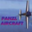

In [4]:
cifar_ex = cifar10['train'][400]
cifar_image = cifar_ex['img']
cifar_image

In [5]:
labels = cifar10['train'].features['label']
labels
labels.int2str(cifar_ex['label'])

'airplane'

In [6]:
from transformers import ViTImageProcessor

model_name_or_path = 'google/vit-base-patch16-224-in21k'
processor = ViTImageProcessor.from_pretrained(model_name_or_path)
print(processor)

preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

ViTImageProcessor {
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_processor_type": "ViTImageProcessor",
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 224,
    "width": 224
  }
}



In [7]:
print(processor(cifar_image, return_tensors='pt')['pixel_values'].shape)

torch.Size([1, 3, 224, 224])


In [8]:
def process_example(example):
    inputs = processor(example['img'], return_tensors='pt')
    inputs['label'] = example['label']
    return inputs


In [9]:
def transform(batch):
    inputs = processor([img for img in batch['img']], return_tensors='pt')
    inputs['label'] = batch['label']
    return inputs

In [10]:
train_transformed = train_set.with_transform(transform)
val_transformed   = val_set.with_transform(transform)
test_transformed  = test_set.with_transform(transform)

In [11]:
import torch

def collate_fn(batch):
  return {
      'pixel_values': torch.stack([x['pixel_values'] for x in batch]),
      'labels': torch.tensor([x['label'] for x in batch])
  }

In [12]:
import numpy as np
!pip install evaluate
from evaluate import load

metric = load("accuracy")
def compute_metrics(p):
    return metric.compute(predictions=np.argmax(p.predictions, axis=1), references=p.label_ids)


/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 1.5 MB/s eta 0:00:0000:01


In [13]:
from transformers import ViTForImageClassification

labels = train_set.features['label'].names

model = ViTForImageClassification.from_pretrained(
    model_name_or_path,
    num_labels=len(labels),
    id2label={str(i): c for i, c in enumerate(labels)},
    label2id={c: str(i) for i, c in enumerate(labels)}
)


config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [16]:
from transformers import TrainingArguments
import os
import tempfile
os.environ["WANDB_MODE"] = "disabled"

training_args = TrainingArguments(
  output_dir=tempfile.gettempdir(),
  per_device_train_batch_size=45,
  evaluation_strategy="steps",
  num_train_epochs=1,
  fp16=True,
  save_steps=100,
  eval_steps=100,
  logging_steps=100,
  learning_rate=2e-4,
  save_total_limit=2,
  remove_unused_columns=False,
  push_to_hub=False,
  report_to="none",
  load_best_model_at_end=True,
)


/opt/conda/lib/python3.10/site-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


# Without Fine Tuning

In [17]:
evaluater = Trainer(
    model=model,
    args=training_args,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    train_dataset=train_transformed,
    eval_dataset=val_transformed,
    tokenizer=processor,
)
metrics = evaluater.evaluate(test_transformed)

print(metrics)



/tmp/ipykernel_23/3795962615.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  evaluater = Trainer(


{'eval_loss': 2.2960503101348877, 'eval_model_preparation_time': 0.0036, 'eval_accuracy': 0.166, 'eval_runtime': 84.6298, 'eval_samples_per_second': 118.162, 'eval_steps_per_second': 14.77}


# With fine-tuning

In [18]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    train_dataset=train_transformed,
    eval_dataset=val_transformed,
    tokenizer=processor,
)

/tmp/ipykernel_23/340975248.py:3: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [19]:
import time

tic = time.time()
train_results = trainer.train()
toc = time.time()
print(f"That took {toc - time} seconds.")
trainer.log_metrics("train", train_results.metrics)
trainer.save_metrics("train", train_results.metrics)
trainer.save_state()
metrics = trainer.evaluate(test_transformed)
print(metrics)



Step,Training Loss,Validation Loss,Accuracy
100,0.676700,0.370406,0.905400
200,0.255100,0.232464,0.939400
300,0.192700,0.188056,0.947200
400,0.169700,0.141753,0.963000
500,0.140600,0.141289,0.960800
600,0.109100,0.095116,0.974400
700,0.096700,0.089522,0.974600
800,0.083800,0.072069,0.981400
900,0.073300,0.059823,0.983600
1000,0.065900,0.057821,0.982800


TypeError: unsupported operand type(s) for -: 'float' and 'module'

In [21]:
metrics = trainer.evaluate(test_transformed)
